# Kiva

### Kiva is a crowdfunding platform aimed at funding low-income entrepeneurs.

#### How it works:
1. A borrower applies for a loan though a field agent. 
2. The loan undergoes an approval process and is then posted on the Kiva platform. 
3. Anyone can then partake in financing the loan.
4. The field agent distributes the loan to the borrower.
4. The borrower repays the loan.

The lender does not receive any interest.

### Import modules

In [28]:
from IPython.display import HTML
HTML('''<style>.CodeMirror{min-width:100% !important;}</style>''')

In [85]:
%matplotlib inline


import squarify # Treemap Ploting
import geopandas
from shapely.geometry import Point

import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import timedelta
from collections import Counter

# Num visible columns in dataframe
pd.set_option('display.max_columns', 50)
# Activate Seaborn
sns.set()
# Large Plot
matplotlib.rcParams['figure.figsize'] = (14.0, 8.0)
# Use ggplot style
style.use('ggplot')

## Load data

In [30]:
df_loans = pd.read_csv('./data/kiva_loans.csv')
df_mpi = pd.read_csv('./data/kiva_mpi_region_locations.csv')
df_theme_region = pd.read_csv('./data/loan_themes_by_region.csv')
df_theme_ids = pd.read_csv('./data/loan_theme_ids.csv')

### First look at the loan data

In [117]:
df_loans.iloc[0]

id                                                     653051
funded_amount                                             300
loan_amount                                               300
activity                                  Fruits & Vegetables
sector                                                   Food
use                   To buy seasonal, fresh fruits to sell. 
country_code                                               PK
country                                              Pakistan
region                                                 Lahore
currency                                                  PKR
partner_id                                                247
posted_time                         2014-01-01 06:12:39+00:00
disbursed_time                      2013-12-17 08:00:00+00:00
funded_time                         2014-01-02 10:06:32+00:00
term_in_months                                             12
lender_count                                               12
tags    

 Note that it is possible for the money to be disbursed to borrowers before the loan is posted on Kiva.

#### Key column descriptions:

* id: Unique ID for loan
* loan_amount: Requestet loan amount [USD]
* sector: High level category
* use: Exact usage of loan amount
* country: Full country name of country in which loan was disbursed
* lender_count: The total number of lenders that contributed to this loan
* borrower_genders: Comma separated M,F letters, where each instance represents a single male/female in the group


### Number of unique values in each column

In [32]:
for col in df_loans.columns:
    print("{} : {}".format(col, df_loans[col].nunique()))

id : 671205
funded_amount : 610
loan_amount : 479
activity : 163
sector : 15
use : 424912
country_code : 86
country : 87
region : 12695
currency : 67
partner_id : 366
posted_time : 667399
disbursed_time : 5719
funded_time : 498007
term_in_months : 148
lender_count : 503
tags : 86719
borrower_genders : 11298
repayment_interval : 4
date : 1298


```
The dataset contains 671 206 loans to borrowers in 87 countries.
Intended use of money is varied across many sectors.
The number of genders seems odd.
```

### Number of missing values in each column

In [33]:
rows_with_nan = df_loans.isnull().any(axis=1).sum()
print("{} rows have one or more missing values".format(rows_with_nan))

248124 rows have one or more missing values


In [34]:
for col in df_loans.columns:
    print("{} : {}".format(col, df_loans[col].isnull().sum()))

id : 0
funded_amount : 0
loan_amount : 0
activity : 0
sector : 0
use : 4232
country_code : 8
country : 0
region : 56800
currency : 0
partner_id : 13507
posted_time : 0
disbursed_time : 2396
funded_time : 48331
term_in_months : 0
lender_count : 0
tags : 171416
borrower_genders : 4221
repayment_interval : 0
date : 0


```
Majority of missing data is in three of the columns, "tags", "region" and "funded time"
```

### Gender distribution in loan applications

#### Number of unique values in  "borrower_gender" column is suspiciously large

In [35]:
df_loans["borrower_genders"].value_counts()[:5]

female                            426502
male                              134710
female, female                     12164
female, female, female             11676
female, female, female, female      9052
Name: borrower_genders, dtype: int64

```
The gender of each recipient of a particular loan is included.
There seems to be a majority of female borrowers
```

### Visualize gender distribution in loan applications

In [36]:
# Total nummber of females
n_females = df_loans["borrower_genders"].str.count('female').sum()

# Total number of males
n_males = df_loans["borrower_genders"].str.count(r'^male').sum()

# New column where loans with multiple borrowers are given the gender "group"
df_loans["gender_simplified"] =\ 
["single " + gender if gender in ["female", "male"] else "group" for gender in df_loans["borrower_genders"]]

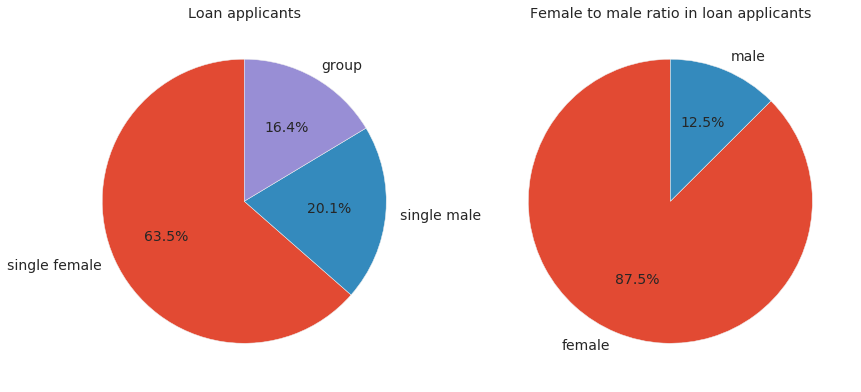

In [86]:
plt.subplot(1, 2, 1)

gender_counts = df_loans["gender_simplified"].value_counts()
plt.pie(x=gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', 
        startangle=90, textprops={'fontsize': 14})
plt.title("Loan applicants")

plt.subplot(1, 2, 2)

plt.pie(x=[n_females, n_males], labels=["female", "male"], autopct='%1.1f%%', 
        startangle=90, textprops={'fontsize': 14})
plt.title("Female to male ratio in loan applicants")

plt.show()

### Visualize country of origin of loan applicants

In [38]:
# Extract coordinates from df_theme_region and convert them to Points
df_theme_region['coordinates'] = list(zip(df_theme_region['lon'], 
                                          df_theme_region['lat']))
df_theme_region['coordinates'] = df_theme_region['coordinates'].apply(Point)

In [57]:
# Create GeoDataFrame and load map
gdf = geopandas.GeoDataFrame(df_theme_region[['coordinates']], 
                             geometry='coordinates')
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

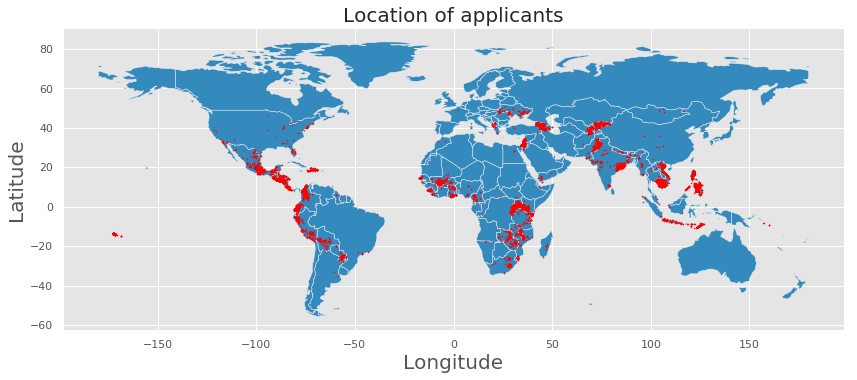

In [87]:
# Draw world
ax = world[(world.continent != 'Antarctica')].plot()

# Plot GeoDataFrame.
gdf.plot(ax=ax, color='red', markersize=1)

# Set labels
ax.set_title('Location of applicants', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
ax.set_xlabel('Longitude', fontsize=20)

plt.show()

In [62]:
# whats the cluster of points west of the americas
df_theme_region[(df_theme_region['lat'].between(-20, 0)) & 
                 df_theme_region['lon'].between(-200, -150)]['country'].unique()

array(['Samoa'], dtype=object)

```
Borrowers are primarily located in poorer countries. 
A treemap might be more informative.
```

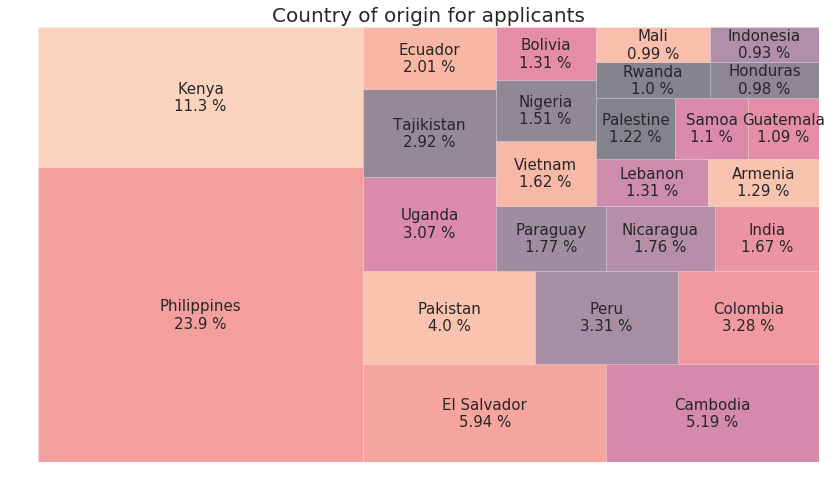

In [127]:
# Nr. of applications (from a country) relative to total number of applications
prct_applic = df_loans["country"].value_counts(normalize=True)[:25]

squarify.plot(sizes=prct_applic.values, label=prct_applic.index  + '\n' + 
              np.round(np.multiply(prct_applic.values, 100), decimals=2).astype(str) + ' %', 
              alpha=.5, text_kwargs={"fontsize":15})

plt.axis('off')
plt.title('Country of origin for applicants', fontsize=20)
plt.show()

```
The Philippines and Kenya account for more than 30 % of the applications
```

### What's the intended use of the loans?

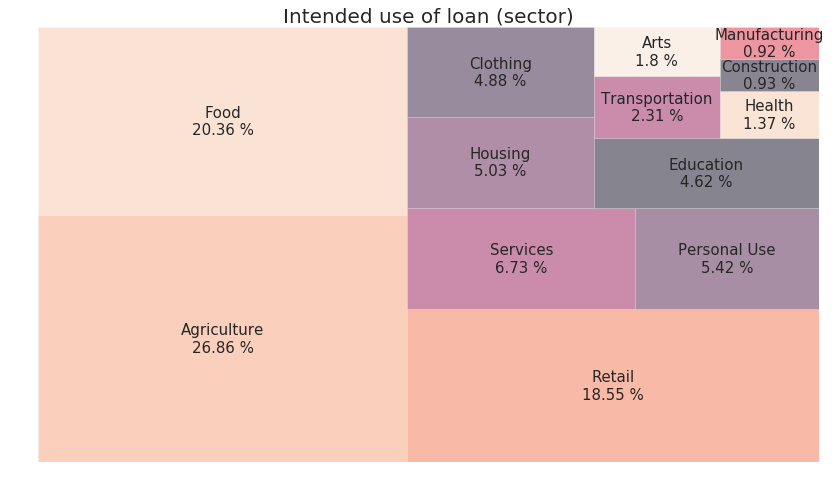

In [89]:
prct_sector = df_loans["sector"].value_counts(normalize=True)[:13]

squarify.plot(sizes=prct_sector.values, label=prct_sector.index  + '\n' + 
              np.round(np.multiply(prct_sector.values, 100), decimals=2).astype(str) + ' %', 
              alpha=.5, text_kwargs={"fontsize":15})

plt.axis('off')
plt.title('Intended use of loan (sector)', fontsize=20)
plt.show()

```
Agriculture and Food account for nearly 50 % of the applications
```

### Some uses within the agriculture sector

In [72]:
uses = df_loans[df_loans["sector"].str.contains("Agriculture")]
for i in range(5):
    print("{} USD {}".format(uses["loan_amount"].iloc[i], uses["use"].iloc[i]))

200.0 USD To purchase a dairy cow and start a milk products business .
225.0 USD to expand her existing  poultry farm business.
250.0 USD to purchase potato seeds and fertilizers for growing potatoes on her own land.
125.0 USD to purchase potato seeds and fertilizers for growing potatoes.
250.0 USD to purchase potato seeds and fertilizer for farming potatoes.


### Some uses within the food sector

In [73]:
uses = df_loans[df_loans["sector"].str.contains("Food")]
for i in range(5):
    print("{} USD {}".format(uses["loan_amount"].iloc[i], uses["use"].iloc[i]))

300.0 USD To buy seasonal, fresh fruits to sell. 
400.0 USD to purchase one buffalo.
625.0 USD to buy a stall, gram flour, ketchup, and coal for selling ladoo.
250.0 USD to buy ingredients to make bakery products. 
350.0 USD to purchase vegetables, chicken, and oil to cook food to sell.


### Most popular intended use overall

In [47]:
df_loans["use"].value_counts()[:10]

to buy a water filter to provide safe drinking water for their family.    5217
to buy a water filter to provide safe drinking water for her family.      4082
To buy a water filter to provide safe drinking water for their family.    2141
to build a sanitary toilet for her family.                                1708
to build a sanitary toilet for her family                                 1599
to buy ingredients for her food production business                       1419
to purchase more groceries to sell.                                       1409
to buy feed and other supplies to raise her pigs.                         1405
to buy fertilizers and other farm supplies.                               1280
to buy a water filter to provide safe drinking water for his family.      1261
Name: use, dtype: int64

### Analyze requestet loan amount

#### How many of the loans ends up being funded?

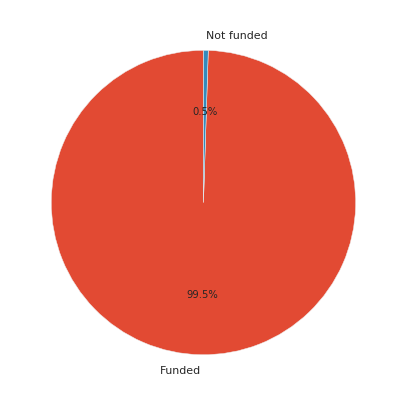

In [90]:
f = plt.figure(figsize=(7, 7))
plt.pie(x=[(df_loans["funded_amount"] != 0).sum(), 
           (df_loans["funded_amount"] == 0).sum()], 
        labels=["Funded", "Not funded"], autopct='%1.1f%%', startangle=90)
plt.show()

#### Which gender is is borrowing more money?

In [154]:
df_loans.groupby(["gender_simplified"])["loan_amount"].mean().sort_values(ascending=False)

gender_simplified
group            1739.715936
single male       899.039047
single female     593.092236
Name: loan_amount, dtype: float64

```
Groups borrows more money on average. 
Projects with multiple people are probably larger and requires more funding.
Men borrows more money on average
```

#### What is the size of the loans within the different sectors?

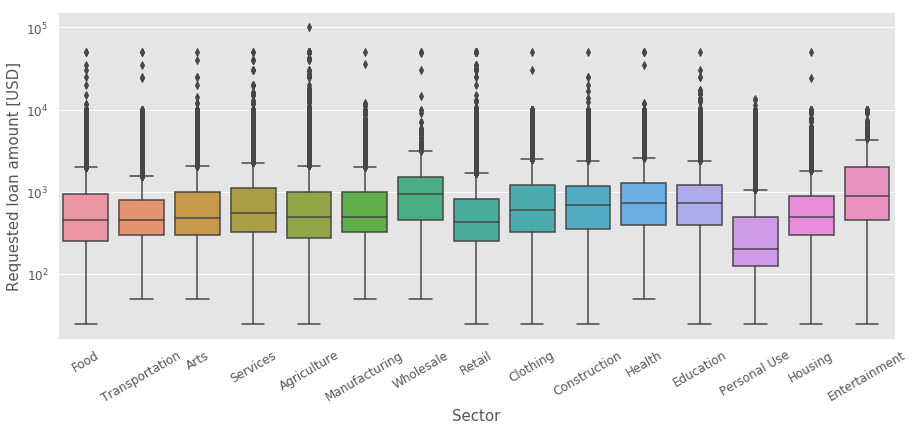

In [93]:
f = plt.figure(figsize=(15, 6))
ax = sns.boxplot(x=df_loans["sector"], y=df_loans["loan_amount"])
ax.set(yscale="log")

ax.set_ylabel('Requested loan amount [USD]', fontsize=15)
ax.set_xlabel('Sector', fontsize=15)
plt.yticks(fontsize=12) 
plt.xticks(rotation=30, fontsize=12)
plt.show()

```
The median loan amount is between 100 USD and 1000 USD for all sectors.
The largest loan amount is 100 000 USD.
Loan amount in the Personal Use sector is noticeably lower on average
```

#### What is the 100 000 USD loan for?

In [50]:
df_loans["use"].iloc[df_loans["loan_amount"].values.argmax()]

'create more than 300 jobs for women and farmers in rural Haiti.'

### Which country has received most USD in loans?

In [158]:
df_loans.groupby("country").loan_amount.agg(["min","max","median","mean","sum"]).\
astype(int).sort_values(by="sum", ascending=False).T

country,Philippines,Kenya,United States,Peru,Paraguay,El Salvador,Cambodia,Bolivia,Rwanda,Uganda,Tajikistan,Ecuador,Vietnam,Colombia,Pakistan,Palestine,Armenia,Lebanon,Guatemala,The Democratic Republic of the Congo,Nicaragua,Mexico,Mali,Kyrgyzstan,Senegal,...,Moldova,Brazil,South Africa,Suriname,Benin,Solomon Islands,Thailand,China,Puerto Rico,Lesotho,Nepal,Panama,Somalia,Chile,South Sudan,Belize,Cote D'Ivoire,Saint Vincent and the Grenadines,Namibia,Bhutan,Mauritania,Afghanistan,Virgin Islands,Vanuatu,Guam
min,25,25,125,50,25,50,25,75,25,25,25,100,50,50,25,150,25,25,100,50,50,50,25,150,75,...,450,200,300,275,200,175,150,325,500,425,50,150,300,2750,100,150,50000,750,3325,10000,15000,6000,5000,1375,4300
max,25000,50000,10000,50000,16275,3000,30000,7950,50000,50000,5000,50000,6175,40000,50000,5000,4250,12000,50000,10000,6075,50000,49250,8000,6150,...,5000,30000,3850,3975,50000,3600,3600,8000,10000,2400,13875,30000,8000,49925,50000,2975,50000,4000,5100,10000,15000,8000,5000,3350,4300
median,275,325,5000,900,2425,550,325,1450,1625,600,650,1000,900,525,400,1500,1475,1300,950,3150,725,900,1025,1100,1975,...,2050,2100,1425,2475,625,875,2300,3025,5000,825,375,1000,1500,5687,312,625,50000,3687,4075,10000,15000,7000,5000,2262,4300
mean,344,455,5169,1388,2489,667,570,2253,2471,747,767,1109,1373,655,495,1600,1496,1382,1561,3664,899,1691,1353,1238,2151,...,2065,2331,1518,2469,1044,925,2367,2839,5461,851,429,1415,3011,12265,755,912,50000,3076,4046,10000,15000,7000,5000,2312,4300
sum,55342225,34534300,31496375,30867400,29629075,26603650,19872700,19843250,16646300,15389350,15030350,15000275,14891450,14415600,13294750,13070900,12915400,12158800,11414000,11261150,10601950,9711000,8986700,7152300,7033925,...,718725,662200,574025,550800,518950,512550,426100,380525,371400,359525,307625,273275,225875,122650,120900,114025,50000,49225,32375,20000,15000,14000,10000,9250,4300


```
Applicants from united states has in total received the 3rd most in loans, while not being among the top 25 countries in number of applications. The median loan amount for the united states seems to be significantly higher than for other countries.
```

#### Loan use in the USA

In [132]:
uses = df_loans[df_loans["country"].str.contains("United States")]
for i in range(4):
    print("{} USD {}".format(uses["loan_amount"].iloc[i], uses["use"].iloc[i]))

5000.0 USD hire more staff to keep up with the volume of orders coming in.
4000.0 USD to purchase more inventory to sell
10000.0 USD outfit my new kitchen so that I can expand my production capabilities.
5000.0 USD to purchase a tractor


#### Loan use in the Philippines

In [133]:
uses = df_loans[df_loans["country"].str.contains("Philippines")]
for i in range(4):
    print("{} USD {}".format(uses["loan_amount"].iloc[i], uses["use"].iloc[i]))

175.0 USD to buy piglets and feed
175.0 USD to purchase feed and vitamins for her pigs
700.0 USD to buy additional items like eggs, charcoal, rice, Milo, shampoo, groceries, etc. to sell 
575.0 USD to purchase fertilizers and other farm supplies


The loans going towards the US seems to be directed to larger business ventures. Cost of equipment and labor is also likely to be larger.

### Time until loan gets funded

##### Key columns:

* posted_time: The time at which the loan is posted on Kiva by the field agent
* funded_time: The time at which the loan posted to Kiva gets funded by lenders completely
* disbursed_time: The time at which the loan is disbursed by the field agent to the borrower

In [109]:
pd.options.mode.chained_assignment = None

# New dataframe. Remove rows where any of the date columns is nan
dates = df_loans.dropna(subset=["posted_time", "funded_time"], how="any", inplace=False)

# Fix date formatting
date_columns = ["posted_time","funded_time"]
dates[date_columns] = dates[date_columns].applymap(lambda x : x.split("+")[0])

# Convert dates from object to datetime
dates[date_columns]=dates[date_columns].apply(pd.to_datetime)

# Calculate time between loan is posted until it"s funded
dates["time_until_funding"] = dates["funded_time"] - dates["posted_time"]

# Convert hours to days and add to days
dates["days_until_funding"] = dates["time_until_funding"] / timedelta(days=1) 

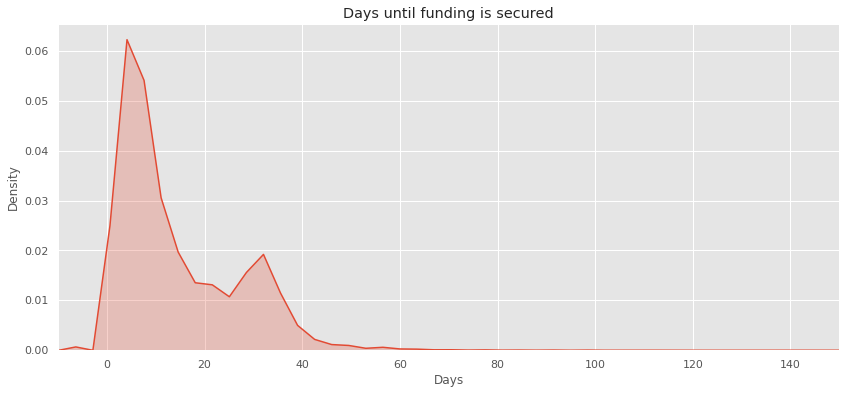

In [113]:
f = plt.figure(figsize=(14, 6))
sns.kdeplot(data=dates["days_until_funding"],shade=True, legend=False)

plt.title("Days until funding is secured")
plt.xlabel("Days")
plt.ylabel("Density")

plt.xlim(-10,150)
plt.show()

```
The majority of loans are funded within 20 days
At least one loan was funded before it was posted. Mistake?
```

### Correlation between loand amount and time to get funding

In [147]:
corr = dates[["funded_amount", "days_until_funding"]].corr()
corr.style.background_gradient(cmap='coolwarm')

,funded_amount,days_until_funding
funded_amount,1,0.139481
days_until_funding,0.139481,1


```
There is a slight positive correlation. 
A larger loan request will therefore typically take longer to gather funding.
```

### Summary

* The Philippines and Kenya account fo ~ 30 % of all loan applications.
* 87.5 % of the borrowers are women.
* Men borrows more money than women on average.
* Almost 50 % of the loans are intended for use in the agriculture and food sectors.
* 99.5 % of the loan requests ends up being funded (bias in provided dataset?)
* The median loan amount is between 100 - 1000 USD in all sectors.
* Most loans have secured funding within 3 weeks.
* There is a positive correlation between size of loan and time taken to secure funding.
* Although the majority of applications are from poor countries, more than 31 million USD went to borrowers from the United States.